In [8]:
import os
from pathlib import Path
import scipy
import matplotlib.pyplot as plt
import numpy as np
import mne
from matplotlib import ticker
from tqdm.auto import tqdm
import textwrap
from typing import Union, List
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

d:\new project\PD_&_EEG_Analysis\Parkinson_disease-EEG_Data_Analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
notebook_journal = [ ] # This holds the notes for the models
mne.set_log_level("ERROR")
plt.ioff()


In [10]:
def gather_all_setFile_paths():
    return list(Path("ds004584-download").glob("**/*.set"))

def find_set_of_common_channels(filePaths):
    for idx,filepath in tqdm(enumerate(filePaths),total=len(filePaths), desc="Finding the set of common channels"):
        raw = mne.io.read_raw_eeglab(filepath)
        ch_names = raw.ch_names
        if idx == 0 :
            ch_names_holder = ch_names
        else: 
            ch_names_holder = list(set(ch_names_holder) & set(ch_names))
    return ch_names_holder

In [11]:
def get_sub_info(subject_id:str) -> pd.DataFrame:
    assert isinstance(subject_id,str),f"The subject_id has to be a string, got{type(subject_id)}"
    path_sub_info = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download", 
        "participants.tsv")
    df_sub_info = pd.read_csv(path_sub_info,sep='/t')
    df_sub_info = df_sub_info[df_sub_info.participant_id ==str(subid)]
    return df_sub_info

def get_sub_data(sub_id:str) ->pd.DataFrame:
    assert isinstance(subject_id, str), f"The subject_id has to be a string, got {type(subject_id)}"
    
    # Find the EEGLab set file
    path_sub_dir = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download",
        str(subject_id)
    )
    path_sub_set_file = list(path_sub_dir.glob("**/*"))
    if len(path_sub_set_file) > 1:
        raise Exception("More than one set file is found")
    else:
        path_sub_set_file = path_sub_set_file[0]
        raw = mne.io.read_raweeglab(path_sub_set_file)
        df_raw_eeg = pd.DataFrame(raw.get_data())
        df_raw_eeg["channel_name"] = raw.ch_names
        df_raw_eeg = df_raw_eeg.set_index("channel_name")
        return df_raw_eeg

In [12]:
def calculate_band_power(
    filepath:Path,
    channels:Union,
    brain_wave_bands:dict=None) -> pd.DataFrame:

    if brain_wave_bands is None:
        brain_wave_bands=dict(
            low_theta=(2,5),
            high_theta=(6,9),
            alpha=(10,15),
            beta=(16,25),
            low_gamma=(36,55),
            high_gamma_1=(65,89),
            high_gamma_2=(90,115)
            )
    raw = mne.io.read_raw_eeglab(filepath)
    spectrum = raw.compute_psd(picks=channels,n_jobs=-1)
    data,freqs = spectrum.get_data(return_freqs=True)
    holder_stats=np.ndarray((data.shape[0],len(brain_wave_bands)))

    for idx, (key,val) in enumerate(brain_wave_bands.items()):
        low_bound,high_bound = val[0],val[1]
        
        indices = np.argwhere(
            np.logical_and(
                freqs >= low_bound,
                freqs <= high_bound,
                
            )
        )
        holder_stats[:, idx] = np.sum(data[:, indices],axis=1).ravel()
    assert holder_stats.shape == (data.shape[0], len(brain_wave_bounds)),"Something is wrong."
    df_stats = pd.DataFrame(holder_stats)
    df_stats.columns = brain_wave_bounds.keys()
    df_stats["channel_name"] = channels
    df_stats = df_stats.set_index("channel_name")
    return df_stats

def create_df_band_power(filePaths:List[Path], channels:List[str]=None) -> pd.DataFrame:
    if channels is None:
        common_channels = find_set_of_common_channels(filePaths)
    
    holder_df = []
    
    for filepath in tqdm(filePaths,total=len(filePaths),desc="Creating a dataframe of band powers"):
        df_band_power = calculate_band_power(filePaths,common_channels)
        participant_id = filepath.stem[:7]
        df_band_power["participant_id"] = [participant_id] * df_band_power.shape[0]
        df_band_power = df_band_power.reset_index()
        df_band_power = df_band_power.set_index(["participant_id","channel_name"])
        holder_df.append(df_band_power)
    
    df_band_powers= pd.concat(holder_df)
    
    return df_band_powers
    

In [13]:
def create_df_sub_info() -> pd.DataFrame:
    path_sub_info = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download", 
        "participants.tsv")
    df_sub_info = pd.read_csv(path_sub_info,sep="\t")
    return df_sub_info

def create_df_psd(filePaths:List[Path],channels:List[str]=None) -> pd.DataFrame:
    if channels is None:
        common_channels = find_set_of_common_channels(filePaths)
    holder_df=[]
    
    for filepath in tqdm(filePaths, total=len(filePaths), desc="Creating DataFrame of PSD"):
        raw = mne.io.read_raw_eeglab(filepath)
        spectrum = raw.compute_psd(picks=common_channels,n_jobs=-1)
        data,freqs = spectrum.get_data(return_freqs=True)
        participant_id = filepath.stem[:7]
        df_psd= pd.DataFrame(data)
        df_psd["channel_name"] = common_channels
        df_psd["participant_id"] = participant_id
        df_psd = df_psd.set_index(["participant_id","channel_name"])
        holder_df.append(df_psd)
        
    df_psd = pd.concat(holder_df)
    return df_psd



# EDA

In [14]:
# Getting all the paths to the EEGLab '.set' files
filePaths = gather_all_setFile_paths()

In [15]:
# EDA
ith_path = 5

## Extract and read the EEGLab set/fdt file
filePath = filePaths[ith_path]
rawEegLab = mne.io.read_raw_eeglab(filePath)

print(f"Number of channels: {len(rawEegLab.ch_names)}")
print(f"Number of time points: {rawEegLab.n_times}")

Number of channels: 63
Number of time points: 131030


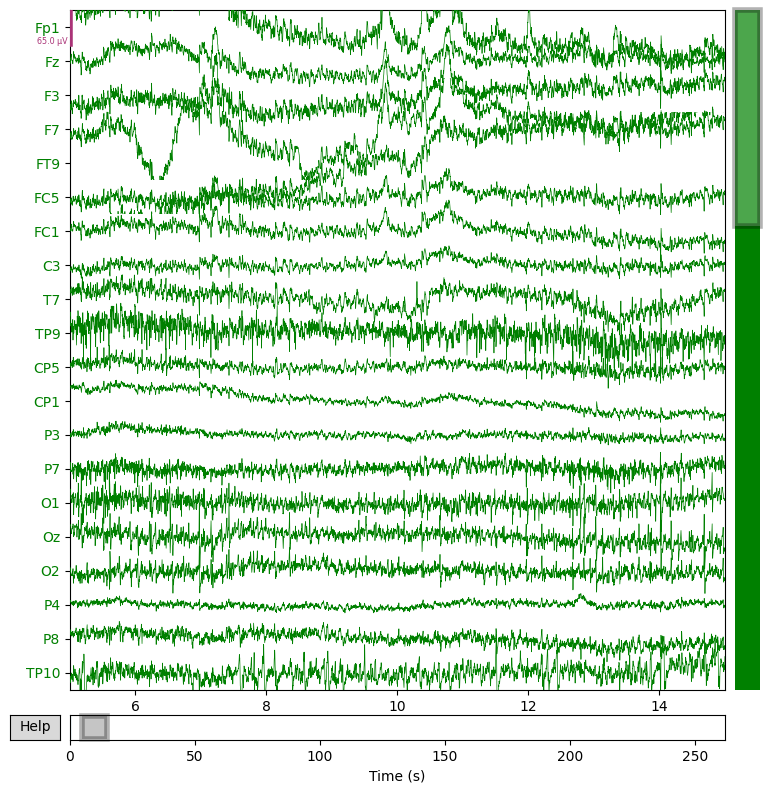

In [16]:
rawEegLab.plot(
        n_channels=20,
        color="green",
        start=5,
        duration=10,
        scalings='auto',  # Automatically scale the plots
        title='Raw EEG Data',
        show_scrollbars=True,
        block=True  # Ensures the plot window stays open
    )
plt.show()

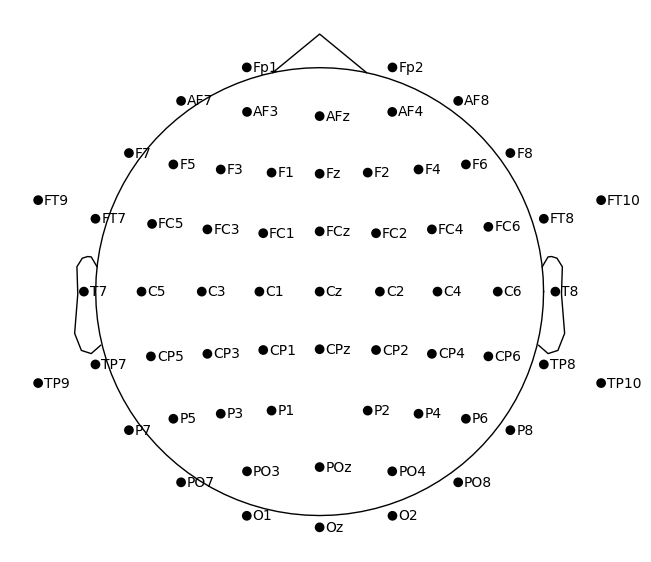

In [17]:
rawEegLab.plot_sensors(show_names=True)
plt.show()

d:\new project\PD_&_EEG_Analysis\Parkinson_disease-EEG_Data_Analysis\env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


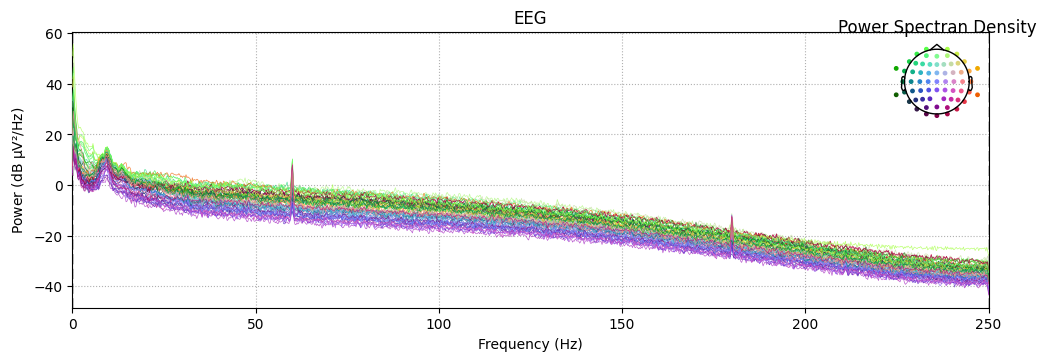

In [18]:
# Power spectral density
rawEegLab.compute_psd().plot(dB=True)
plt.title("Power Spectran Density")
plt.show()

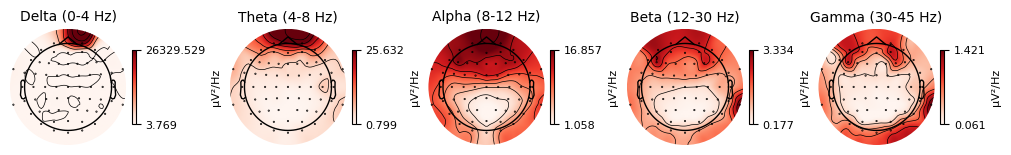

In [19]:
# PSD Tropology map
rawEegLab.compute_psd().plot_topomap()
plt.show()

C:\Users\mdmnb\AppData\Local\Temp\ipykernel_23548\3498534638.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


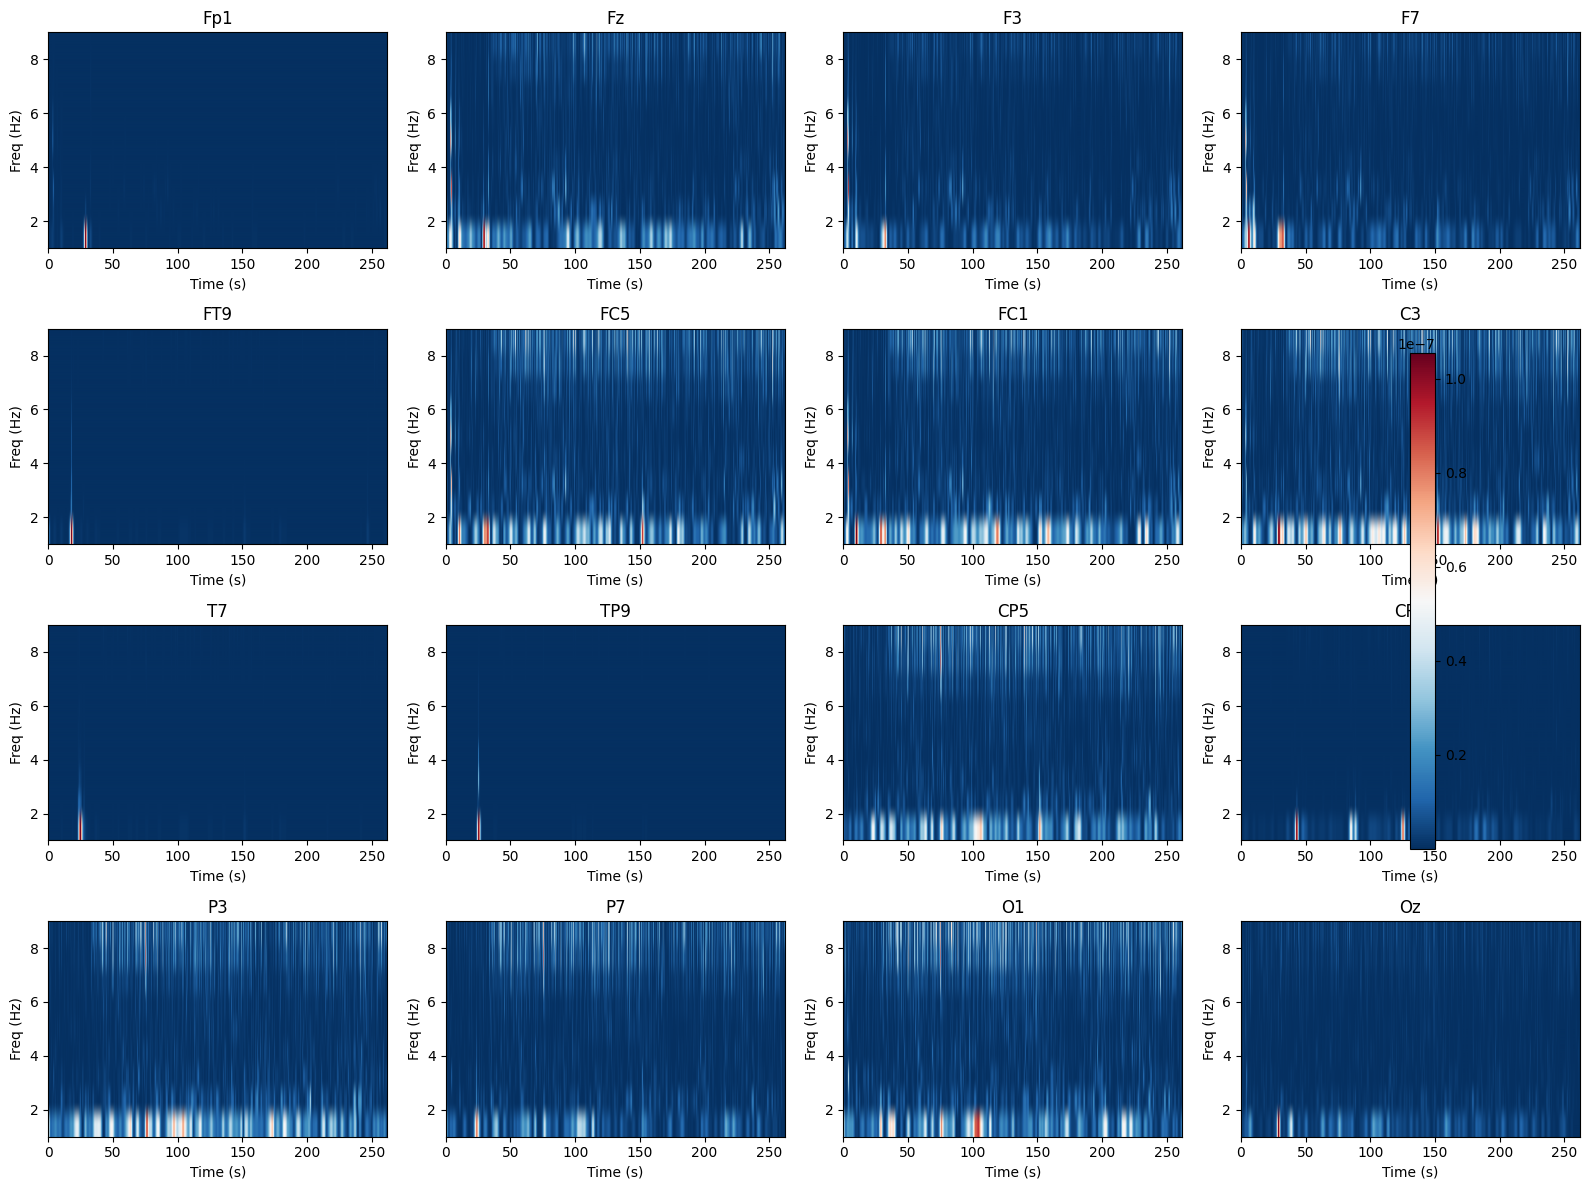

In [20]:
# ...existing code...

subset_channels = rawEegLab.ch_names[:16]
rawTfr = rawEegLab.compute_tfr("morlet", list(range(1, 10)), n_jobs=-1, picks=subset_channels)

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, ch_name in enumerate(subset_channels):
    ax = axes[idx]
    # Get the TFR data for this channel
    ch_idx = rawTfr.ch_names.index(ch_name)
    tfr_data = rawTfr.data[ch_idx]
    # Plot the TFR as an image
    im = ax.imshow(
        tfr_data,
        aspect='auto',
        origin='lower',
        extent=[rawTfr.times[0], rawTfr.times[-1], rawTfr.freqs[0], rawTfr.freqs[-1]],
        cmap='RdBu_r'
    )
    ax.set_title(ch_name)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Freq (Hz)')

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
# ...existing code...

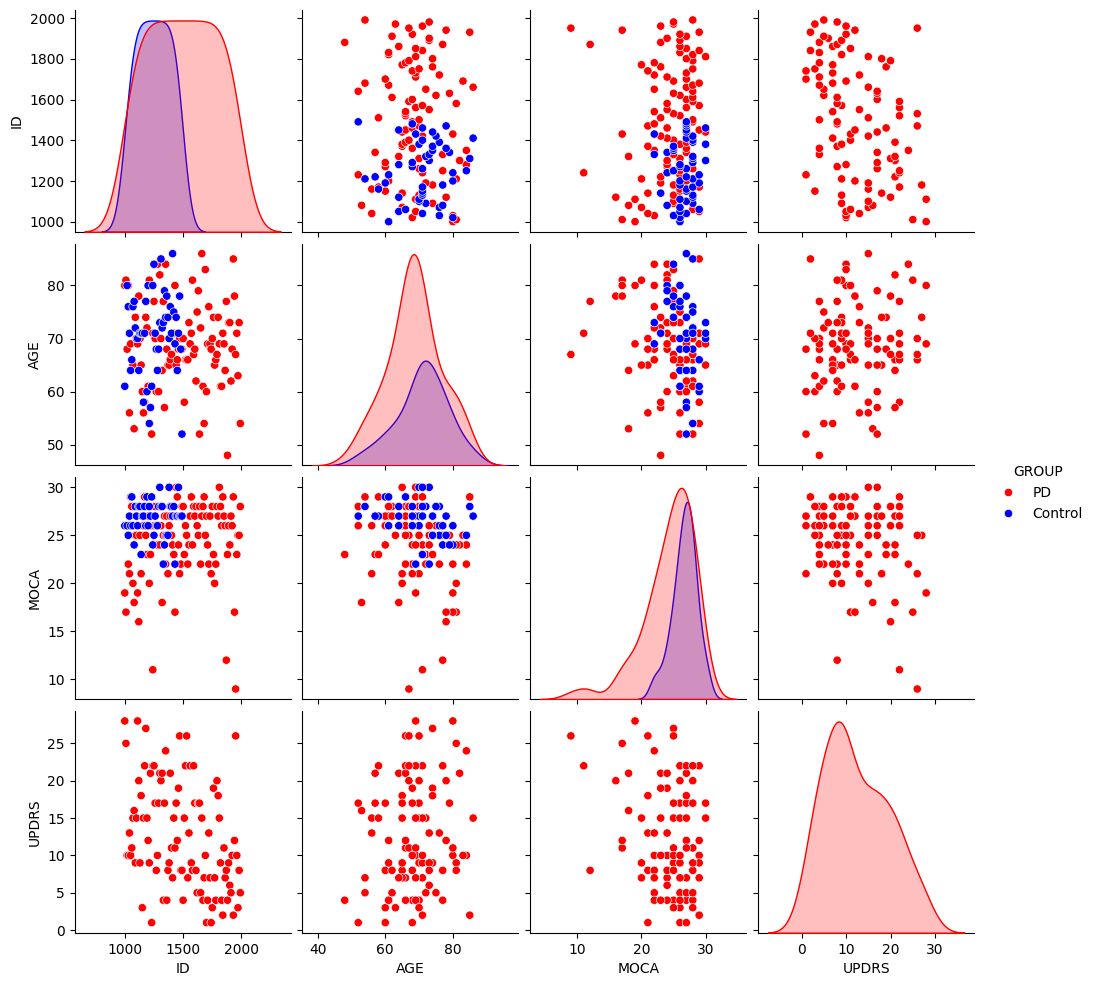

In [21]:
warnings.filterwarnings("ignore")

subject_info = create_df_sub_info()
subject_info.drop("TYPE", axis=1, inplace=True)

sns.pairplot(subject_info, hue="GROUP", palette={"PD":'Red' , "Control": 'Blue'})

plt.show()

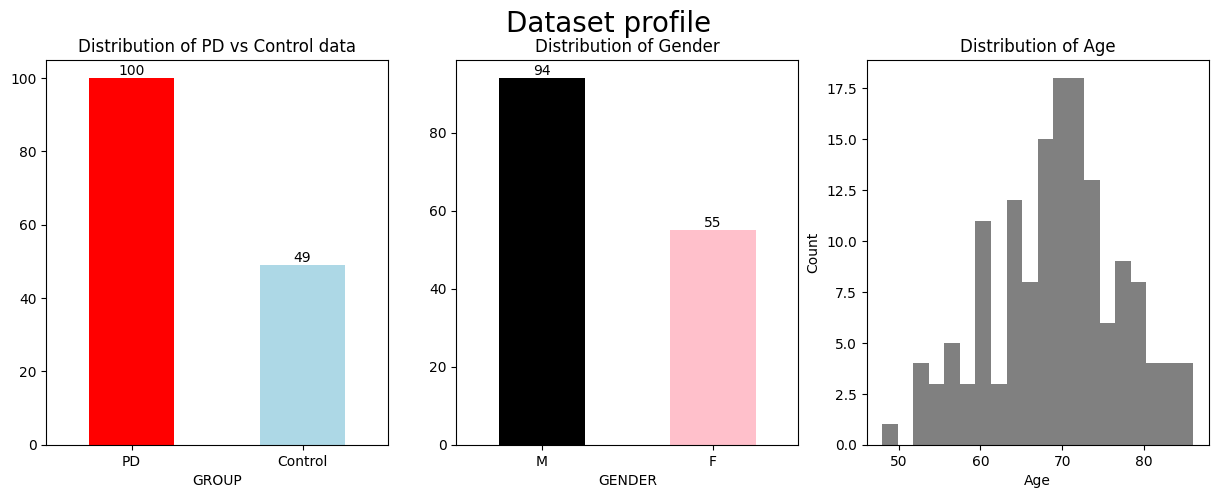

In [22]:
subject_info = create_df_sub_info()

fig,axes = plt.subplots(1,3,figsize=(15,5))

# Ploting PD vs Control
subject_info.GROUP.value_counts().plot(kind="bar",ax=axes[0])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title("Distribution of PD vs Control data")
axes[0].tick_params(labelrotation=0)

# changing the face color of the rectangle

for idx, rec in enumerate(axes[0].containers[0].patches):
    colormap = ["red","lightblue"]
    rec.set(facecolor=colormap[idx])
    
# Ploting Gender
subject_info.GENDER.value_counts().plot(kind="bar",ax=axes[1])
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title("Distribution of Gender")
axes[1].tick_params(labelrotation=0)

# changing the face color of the rectangle

for idx, rec in enumerate(axes[1].containers[0].patches):
    colormap = ["black","pink"]
    rec.set(facecolor=colormap[idx])

# Ploting Age
subject_info.AGE.plot(kind="hist",ax=axes[2],bins=20,color='gray')
axes[2].set_title("Distribution of Age")
axes[2].set_xlabel("Age")
axes[2].set_ylabel("Count")



fig.suptitle("Dataset profile",size='20')
plt.show()

100%|██████████| 149/149 [00:02<00:00, 65.76it/s]


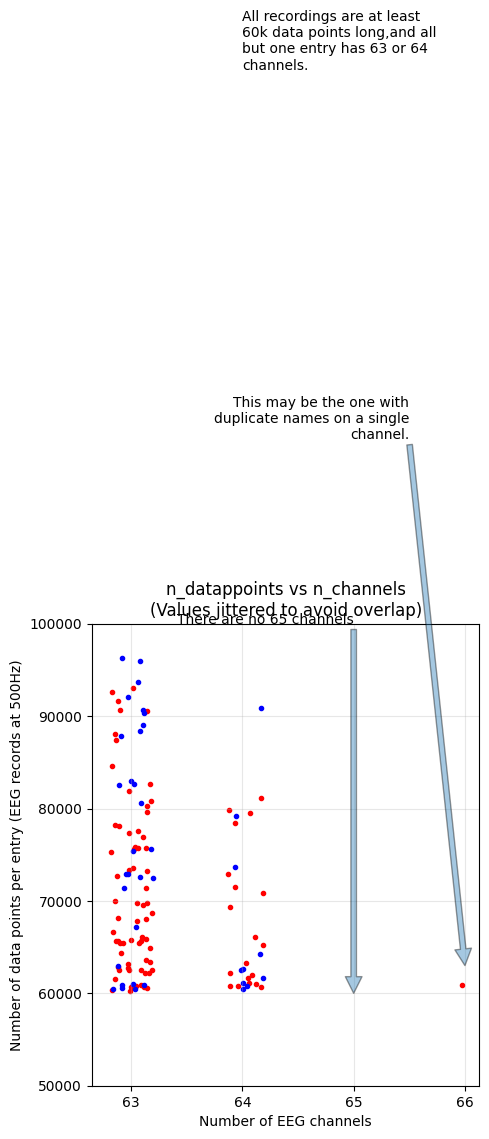

In [23]:
# EDA = Understanding the data - Plotting raw data dimenstions
def add_jitter(value,scale=1):
    return value + np.random.uniform(-1,1) * scale

# Find the entire space of channel_names
holder_ch_names = [ ]
for idx ,filepath in tqdm(enumerate(filePaths),total=len(filePaths)):
    raw = mne.io.read_raw_eeglab(filepath)
    ch_names= raw.ch_names
    holder_ch_names.extend(ch_names)
all_ch_names = list(set(holder_ch_names))

subject_info = create_df_sub_info()

fig,ax = plt.subplots(figsize=(5,6))
for filePath in tqdm(filePaths):
    # Reading the raw EEG data
    raw = mne.io.read_raw_eeglab(filePath)
    n_channels = len(raw.ch_names)
    n_times = raw.n_times
    
    # Determining if PD or Control
    participant_id = filePath.stem[:7]
    mask = subject_info.participant_id == participant_id
    label = subject_info.loc[mask , 'GROUP'].values[0]
    
    # Ploting the scatter plot
    if label =="PD":
        ax.scatter(add_jitter(n_channels,0.2),n_times,marker=".",color="red",label="PD")
    elif label == "Control":
        ax.scatter(add_jitter(n_channels,0.2),n_times,marker=".",color="blue",label="Control")
    else: 
        print(f"Something is wrong at {filePath}")
    
# Adding the labels to the plot
ax.set_title("n_datappoints vs n_channels\n(Values jittered to avoid overlap)")
ax.set_xlabel("Number of EEG channels")
ax.set_ylabel("Number of data points per entry (EEG records at 500Hz)")
ax.set_ylim(50000,100000)
ax.xaxis.set_major_locator(ticker.FixedLocator(range(60,68)))
ax.grid(visible=True,which="both",alpha=0.3)

ax.text(64,16e4,textwrap.fill("All recordings are at least 60k data points long,and all but one entry has 63 or 64 channels.",30))
ax.annotate(
    textwrap.fill("There are no 65 channels"),
    xy=(65,6e4),
    xytext=(65,10e4),
    arrowprops=dict(alpha=0.4),
    ha="right"
)
ax.annotate(
    textwrap.fill("This may be the one with duplicate names on a single channel.",30),
    xy=(66,6.3e4),
    xytext=(65.5,12e4),
    arrowprops=dict(alpha=0.4),
    ha="right"
)
plt.show()

Reading data: 100%|██████████| 149/149 [00:02<00:00, 74.13it/s]


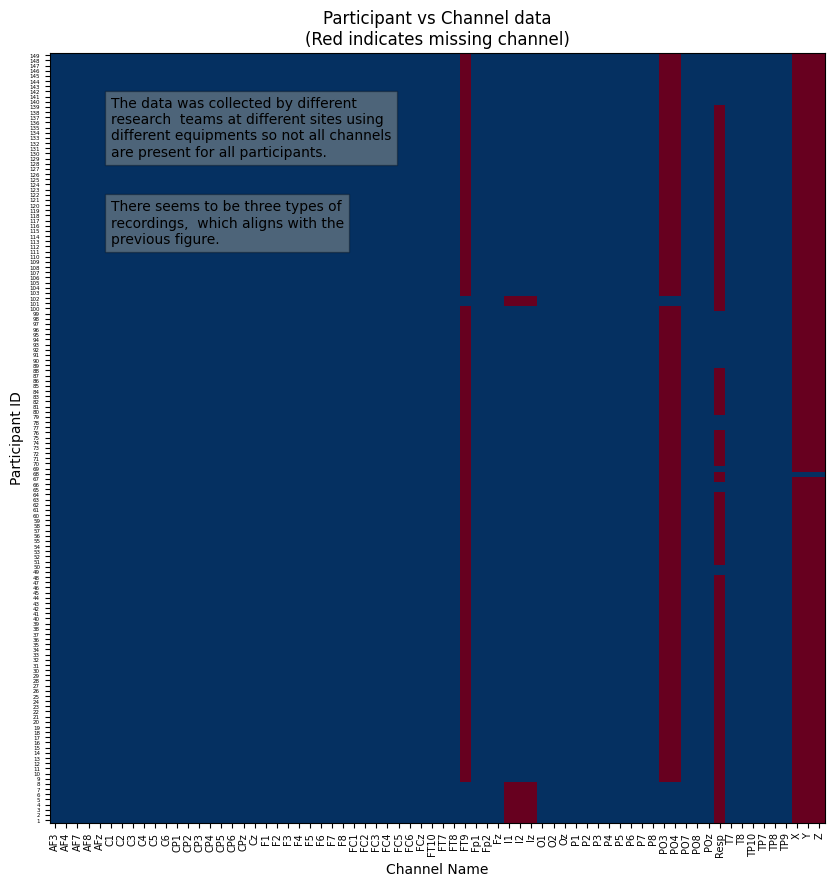

In [24]:
# Create a dataframe indicationg wheather a channel is presence for a participant
from matplotlib import ticker
holder_for_df = []
holder_paricipant_id = []

for idx ,filepath in tqdm(enumerate(filePaths),total=len(filePaths),desc="Reading data"):
    holder_ch_name_presence = []
    raw = mne.io.read_raw_eeglab(filepath)
    ch_names = raw.ch_names
    participant_id = filepath.stem[:7]
    holder_paricipant_id.append(participant_id)
    for ch_name in all_ch_names:
        holder_ch_name_presence.append(ch_name in ch_names)
    holder_for_df.append(holder_ch_name_presence)
    
df_ch_name_presence = pd.DataFrame(holder_for_df)
df_ch_name_presence['participant_id'] = holder_paricipant_id
df_ch_name_presence= df_ch_name_presence.set_index("participant_id").sort_index()
df_ch_name_presence.columns = all_ch_names
df_ch_name_presence = df_ch_name_presence[sorted(all_ch_names)]

# Plot the figure
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(df_ch_name_presence.to_numpy(),aspect='auto',cmap='RdBu',origin='lower')

labels = df_ch_name_presence.columns
positions = range(0,len(labels),1)

ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.yaxis.set_major_locator(ticker.FixedLocator(range(0,df_ch_name_presence.shape[0],1)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(range(1,df_ch_name_presence.shape[0]+1,1)))

ax.tick_params(axis='x',rotation=90,labelsize=7)
ax.tick_params(axis='y',labelsize=4)

ax.set_title("Participant vs Channel data\n(Red indicates missing channel)")
ax.set_ylabel("Participant ID")
ax.set_xlabel("Channel Name")

# Add annotation
text_annotation = """The data was collected by different research 
teams at different sites using different equipments so not all channels
are present for all participants."""

ax.annotate(
    textwrap.fill(text_annotation,40),
    (5,140),
    verticalalignment='top',
    color='black',
    bbox=dict(facecolor='wheat',alpha=0.3)
)

text_annotation = """There seems to be three types of recordings, 
which aligns with the previous figure."""
ax.annotate(
    textwrap.fill(text_annotation, 40), 
    (5, 120), 
    verticalalignment="top", 
    color='black', 
    bbox=dict(facecolor='wheat', alpha=0.3)
)

plt.show()

# MODEL DEVELOPMENT


In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_eeg_features(filePaths, brain_wave_bands=None):
    """Prepare EEG features using existing band power calculation"""
    if brain_wave_bands is None:
        brain_wave_bands = {
            'delta': (1, 4),
            'theta': (4, 8), 
            'alpha': (8, 12),
            'beta': (12, 30),
            'low_gamma': (30, 50),
            'high_gamma': (50, 100)
        }
    
    # Get common channels across all recordings
    common_channels = find_set_of_common_channels(filePaths)
    
    # Calculate band powers using existing function
    df_band_powers = create_df_band_power(filePaths, common_channels)
    
    # Get subject info using existing function
    subject_info = create_df_sub_info()
    
    # Prepare X (features) and y (labels)
    X = []
    y = []
    
    for participant_id in df_band_powers.index.get_level_values('participant_id').unique():
        # Get band powers for this participant
        participant_data = df_band_powers.loc[participant_id].values.flatten()
        X.append(participant_data)
        
        # Get label for this participant
        mask = subject_info.participant_id == participant_id
        label = subject_info.loc[mask, 'GROUP'].values[0]
        y.append(1 if label == 'PD' else 0)
        
    return np.array(X), np.array(y)

# Get file paths using existing function
filePaths = gather_all_setFile_paths()

# Prepare features and labels
X, y = prepare_eeg_features(filePaths)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Train with early stopping
history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training history
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('pd_classification_results.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(class_report)

# Add results to notebook journal
notebook_journal.append({
    'model_type': 'Neural Network',
    'accuracy': accuracy,
    'confusion_matrix': conf_matrix.tolist(),
    'classification_report': class_report
})

Creating a dataframe of band powers:   0%|          | 0/149 [00:00<?, ?it/s]


UnboundLocalError: cannot access local variable 'common_channels' where it is not associated with a value

In [26]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Deep Learning and ML imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scientific computing and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import mne

In [27]:
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)



In [29]:
class EEGDataProcessor:
    """Scalable EEG data processing class"""
    
    def __init__(self, data_path: str = "ds004584-download"):
        self.data_path = Path(data_path)
        self.scaler = None
        self.common_channels = None
        self.brain_wave_bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 12),
            'beta': (12, 30),
            'low_gamma': (30, 50),
            'high_gamma': (50, 100)
        }
    
    def gather_file_paths(self) -> List[Path]:
        """Gather all .set file paths"""
        return list(self.data_path.glob("**/*.set"))
    
    def find_common_channels(self, file_paths: List[Path]) -> List[str]:
        """Find channels common to all recordings"""
        if self.common_channels is not None:
            return self.common_channels
            
        for idx, filepath in enumerate(file_paths):
            raw = mne.io.read_raw_eeglab(filepath, verbose=False)
            ch_names = raw.ch_names
            if idx == 0:
                self.common_channels = set(ch_names)
            else:
                self.common_channels = self.common_channels.intersection(set(ch_names))
        
        self.common_channels = list(self.common_channels)
        return self.common_channels
    
    def extract_spectral_features(self, filepath: Path, channels: List[str]) -> np.ndarray:
        """Extract comprehensive spectral features from EEG data"""
        raw = mne.io.read_raw_eeglab(filepath, verbose=False)
        spectrum = raw.compute_psd(picks=channels, n_jobs=-1, verbose=False)
        data, freqs = spectrum.get_data(return_freqs=True)
        
        features = []
        
        # Band power features
        for band, (low, high) in self.brain_wave_bands.items():
            indices = np.where((freqs >= low) & (freqs <= high))[0]
            if len(indices) > 0:
                band_power = np.sum(data[:, indices], axis=1)
                features.extend([
                    np.mean(band_power),  # Mean band power
                    np.std(band_power),   # Std band power
                    np.max(band_power),   # Max band power
                    np.median(band_power) # Median band power
                ])
        
        # Statistical features across all frequencies
        features.extend([
            np.mean(data),  # Overall mean power
            np.std(data),   # Overall std power
            np.var(data),   # Overall variance
            np.max(data),   # Peak power
            np.min(data),   # Min power
        ])
        
        # Spectral edge frequency (95% of power)
        cumulative_power = np.cumsum(np.mean(data, axis=0))
        total_power = cumulative_power[-1]
        edge_freq_idx = np.where(cumulative_power >= 0.95 * total_power)[0]
        if len(edge_freq_idx) > 0:
            features.append(freqs[edge_freq_idx[0]])
        else:
            features.append(freqs[-1])
        
        # Dominant frequency
        mean_power = np.mean(data, axis=0)
        dominant_freq_idx = np.argmax(mean_power)
        features.append(freqs[dominant_freq_idx])
        
        return np.array(features)
    
    def extract_time_domain_features(self, filepath: Path, channels: List[str]) -> np.ndarray:
        """Extract time domain features"""
        raw = mne.io.read_raw_eeglab(filepath, verbose=False)
        data = raw.get_data(picks=channels)
        
        features = []
        
        for ch_data in data:
            features.extend([
                np.mean(ch_data),           # Mean
                np.std(ch_data),            # Standard deviation
                np.var(ch_data),            # Variance
                np.max(ch_data),            # Maximum
                np.min(ch_data),            # Minimum
                np.median(ch_data),         # Median
                np.percentile(ch_data, 25), # Q1
                np.percentile(ch_data, 75), # Q3
                np.ptp(ch_data),           # Peak-to-peak
                np.mean(np.abs(ch_data)),  # Mean absolute value
            ])
        
        return np.array(features)
    
    def prepare_dataset(self, feature_type: str = 'spectral') -> Tuple[np.ndarray, np.ndarray, List[str]]:
        """Prepare complete dataset with features and labels"""
        file_paths = self.gather_file_paths()
        common_channels = self.find_common_channels(file_paths)
        
        # Load subject info
        subject_info = pd.read_csv(self.data_path / "participants.tsv", sep='\t')
        
        X = []
        y = []
        participant_ids = []
        
        print(f"Processing {len(file_paths)} files...")
        
        for filepath in file_paths:
            try:
                participant_id = filepath.stem[:7]
                
                # Extract features based on type
                if feature_type == 'spectral':
                    features = self.extract_spectral_features(filepath, common_channels)
                elif feature_type == 'time_domain':
                    features = self.extract_time_domain_features(filepath, common_channels)
                elif feature_type == 'combined':
                    spectral_features = self.extract_spectral_features(filepath, common_channels)
                    time_features = self.extract_time_domain_features(filepath, common_channels)
                    features = np.concatenate([spectral_features, time_features])
                
                # Get label
                mask = subject_info.participant_id == participant_id
                if mask.sum() > 0:
                    label = subject_info.loc[mask, 'GROUP'].values[0]
                    X.append(features)
                    y.append(1 if label == 'PD' else 0)
                    participant_ids.append(participant_id)
                    
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                continue
        
        return np.array(X), np.array(y), participant_ids

In [30]:
class DeepLearningModels:
    """Collection of scalable deep learning models for PD classification"""
    def __init__(self,input_dim: int):
        self.input_dim = input_dim
        self.models = {}
        
    def create_basic_mlp(self,dropout_rate:float= 0.2):
        """Basic Multi-Layer Perceptron"""
        model = models.Sequential([
            layers.Dense(256, activation='relu', input_shape=(self.input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate/2),
            
            layers.Dense(32, activation='relu'),
            layers.Dropout(dropout_rate/2),
            
            layers.Dense(1, activation='sigmoid', name='output')
        ])
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model 
    
    def create_deep_mlp(self, dropout_rate: float = 0.4) -> keras.Model:
        """Deeper MLP with residual connections"""
        inputs = layers.Input(shape=(self.input_dim,))
        
        # First block
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
        # Second block with residual
        residual = layers.Dense(256)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        
        # Third block
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate/2)(x)
        
        # Fourth block
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate/2)(x)
        
        # Output
        outputs = layers.Dense(1, activation='sigmoid')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
        
    def create_autoencoder_classifier(self, encoding_dim: int = 64) -> keras.Model:
        """Autoencoder-based classifier"""
        # Encoder
        input_layer = layers.Input(shape=(self.input_dim,))
        encoded = layers.Dense(256, activation='relu')(input_layer)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.3)(encoded)
        encoded = layers.Dense(128, activation='relu')(encoded)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
        
        # Decoder
        decoded = layers.Dense(128, activation='relu')(encoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dense(256, activation='relu')(decoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dense(self.input_dim, activation='linear')(decoded)
        
        # Classifier from encoded representation
        classifier = layers.Dense(32, activation='relu')(encoded)
        classifier = layers.Dropout(0.2)(classifier)
        classifier = layers.Dense(1, activation='sigmoid')(classifier)
        
        # Create models
        autoencoder = models.Model(input_layer, decoded)
        classifier_model = models.Model(input_layer, classifier)
        
        # Compile
        autoencoder.compile(optimizer='adam', loss='mse')
        classifier_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return autoencoder, classifier_model


In [31]:
class ModelTrainer:
    """Scalable model training and evaluation class"""
    
    def __init__(self, model_name:str):
        self.results= {}
        self.trained_models = {}
    
    def get_callbacks(self,model_name:str) -> List[callbacks.Callback]:
        """Get training callbacks"""
        return [
            callbacks.EarlyStopping(
                monitor = "val_loss",
                patience=15,
                restore_best_weights=True,
                verbose=1
                
            )
        ]
        
    def train_model(self,model: keras.Model,X_train:np.ndarray,y_train: np.ndarray,
                    X_val:np.ndarray,y_val:np.ndarray,model_name:str,
                    epochs:int=100,batch_size:int=32) ->Dict:
        """Train a single model"""
        print(F"\n Training {model_name}...")
        
        history = model.fit(
            X_train,y_train,
            validation_data=(X_val,y_val),
            epochs=epochs,
            batch_size=batch_size,
            callback=self.get_callbacks(model_name),
            verbose=1
        )
        
        self.trained_models[model_name] = model
        return history
    
    def evaluate_model(self,model: keras.Model,X_test:np.ndarray,y_test:np.ndarray,
                       model_name:str) -> Dict:
        """Comprehensive model evaluation"""
        
        # Predictions
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics 
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        }
        
        self.results[model_name] = metrics
        return metrics 
    
    def cross_validate_model(self,model_creator,X:np.ndarray,y:np.ndarray,
                             cv_folds: int= 5) -> Dict:
        """Perform cross-validation"""
        skf = StratifiedKFold(n_splits=cv_folds,shuffle=True,random_state=42)
        
        cv_scores = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'auc': []
        }
        
        for fold, (train_idx,val_idx) in enumerate(self.split(X,y)):
            print(f"Training fold {fold+1}/{cv_folds}")
            
            X_fold_train,X_fold_val = X[train_idx],X[val_idx]
            y_fold_train, y_fold_val = y[train_idx],y[val_idx]
            
            # Create and train model
            model = model_creator()
            model.fit(
                X_fold_train, y_fold_train,
                validation_data=(X_fold_val, y_fold_val),
                epochs=50,
                batch_size=32,
                callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                verbose=0    
            )
            
            # Evaluate
            y_pred_proba = model.predict(X_fold_val, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            cv_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            cv_scores['precision'].append(precision_score(y_fold_val, y_pred))
            cv_scores['recall'].append(recall_score(y_fold_val, y_pred))
            cv_scores['f1'].append(f1_score(y_fold_val, y_pred))
            cv_scores['auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
            
        # Calculate mean and std
        cv_results = {}
        for metric,scores in cv_scores.items():
            cv_results[f"{metric}_mean"] = np.mean(scores)
            cv_results[f"{metric}_std"] = np.std(scores)
            
        return cv_results

        



In [ ]:
class Visualizer:
    """Comprehensive visualization class"""
    
    def __init__(self):
        plt.style.use('default')
        
    def plot_training_history(self, histories: Dict, save_path: Optional[str] = None):
        """Plot training histories for multiple models"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training History Comparison', fontsize=16)
        
        metrics = ['loss', 'accuracy', 'precision', 'recall']
        
        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]
            
            for model_name, history in histories.items():
                if metric in history.history:
                    ax.plot(history.history[metric], label=f'{model_name} - Train')
                    ax.plot(history.history[f'val_{metric}'], label=f'{model_name} - Val', linestyle='--')
            
            ax.set_title(f'{metric.capitalize()}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric.capitalize())
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_model_comparison(self, results: Dict, save_path: Optional[str] = None):
        """Compare model performance"""
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
        model_names = list(results.keys())
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar plot
        x = np.arange(len(model_names))
        width = 0.15
        
        for i, metric in enumerate(metrics):
            values = [results[model][metric] for model in model_names]
            axes[0].bar(x + i*width, values, width, label=metric.replace('_', ' ').title())
        
        axes[0].set_xlabel('Models')
        axes[0].set_ylabel('Score')
        axes[0].set_title('Model Performance Comparison')
        axes[0].set_xticks(x + width * 2)
        axes[0].set_xticklabels(model_names, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Heatmap
        heatmap_data = []
        for model in model_names:
            heatmap_data.append([results[model][metric] for metric in metrics])
        
        sns.heatmap(heatmap_data, 
                   xticklabels=[m.replace('_', ' ').title() for m in metrics],
                   yticklabels=model_names,
                   annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1])
        axes[1].set_title('Performance Heatmap')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrices(self, results: Dict, save_path: Optional[str] = None):
        """Plot confusion matrices for all models"""
        n_models = len(results)
        cols = min(3, n_models)
        rows = (n_models + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for i, (model_name, metrics) in enumerate(results.items()):
            cm = metrics['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{model_name}\nAccuracy: {metrics["accuracy"]:.3f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')
        
        # Hide empty subplots
        for i in range(n_models, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
